In [1]:
from tracing.rl.actions import *
from tracing.rl.a3cmodel import A3CModel
from tracing.rl.rewards import PopupRewardsCalculator
from tracing.rl.environment import Environment
from tracing.rl.actor_learner import ActionsMemory
from tracing.rl.actor_learner import ActorLearnerWorker
import tensorflow as tf
import threading
import csv, re
import random

In [4]:
hard_popup_urls = [
    # Choose from two options popups
    'monstervape.com',
    'twistedcigs.com',
    'ecigsejuice.com',
    'vape-fuel.com',
    'www.powervapes.net/products/',
    'ecigexpress.com',
    
    # Subscribe
    'cigarmanor.com',  #Need email or extract close button
    'smokechophouse.com',
    
    
    # Enter date popups
    'thecigarshop.com',
    'cigartowns.com',
    'docssmokeshop.com',
    'enhancedecigs.com',
    'betamorphecigs.com',
    
    # Accept Cookie
    'theglamourshop.com',
    'smokingvaporstore.com',   
]

no_popup_urls = [
    'dixieems.com',
    'firstfitness.com',
    'sandlakedermatology.com',
    'dixieems.com',
    'anabolicwarfare.com',
    'jonessurgical.com',
    'srandd.com'
]


def create_popup_dataset(dataset_file):
    import os.path
    import tracing.selenium_utils.common as common
    
    if os.path.isfile(dataset_file):
        result = []
        with open(dataset_file) as f:
            for row in f:
                url, is_popup = row.strip().split('\t')
                result.append((url, is_popup == '1'))
        return result
    
    print('started creating dataset...')
    
    def create_driver():
        for i in range(10):
            try:
                return common.create_chrome_driver(headless = True, size=(1280, 1024))
            except:
                time.sleep(2)
        
        raise Exception("can't create driver")

        
    smoke_urls = []
    pattern = '.*((smok)|(cig)|(vap)|(tobac)).*'
    with open('../../resources/pvio_vio_us_ca_uk_sample1.csv') as f:
        rows = csv.reader(f)
        for row in rows:
            url = row[0]
            if re.match(pattern, url):
                smoke_urls.append(url)

    print('Found {} urls'.format(len(smoke_urls)))
    
    tmp_file = dataset_file + '.tmp'
    with open(tmp_file, 'w') as f:
    
        driver = create_driver()
        checked_popup_urls = []
        for i, url in enumerate(smoke_urls):
            rewards = PopupRewardsCalculator()
            has_popup = False
            for _ in range(3):
                try:
                    driver.get('http://' + url)
                    has_popup = rewards.is_popup_exists(driver)
                    break
                except:
                    traceback.print_exc()
                    driver.quit()
                    driver = create_driver()
                    continue

            print(i, url, has_popup)        
            if has_popup:
                checked_popup_urls.append(url)
            
            f.write(url)
            f.write('\t')
            f.write('1' if has_popup else '0')
            f.write('\n')
            f.flush()
        
    
    os.rename(tmp_file, dataset_file)
    
    return checked_popup_urls

extracted_popup_urls = create_popup_dataset('popups_dataset.csv')

popup_urls = list([url for (url, is_popup) in extracted_popup_urls if is_popup==True])
random.shuffle(popup_urls)

split = int(len(popup_urls) * 0.8)
train_urls = popup_urls[:split]
test_urls = popup_urls[split:]


In [5]:
tf.reset_default_graph()
session = tf.Session()

num_workers = 4

global_model = A3CModel(len(Actions.actions), session = session, train_deep = False)
session.run(tf.global_variables_initializer())
global_model.init_from_checkpoint('inception_resnet_v2_2016_08_30.ckpt')

workers = []

for i in range(num_workers):
    env = Environment(PopupRewardsCalculator(), user={}, headless=True)
    worker = ActorLearnerWorker("worker-{}".format(i),
                                train_urls,
                                global_model, 
                                env, 
                                1000, 
                                n_step = 10, 
                                lr=0.001, 
                                l2 = 0.03,
                                entropy_l=0.2, 
                                dropout = 0.8, 
                                gamma=0.99)
    workers.append(worker)
    
coord = tf.train.Coordinator()

INFO:tensorflow:Restoring parameters from inception_resnet_v2_2016_08_30.ckpt




started url http://xfirevapor.com


started url http://easyvapors.com


started url http://strongislandvapes.com


started url http://vapealotshop.com
control: Control: select, label: , values: ['January', 'February', 'March', 'April', 'May', 'June', 'July', '
got probabilities: [7.2785190e-07 6.2589562e-01 1.1894435e-06 8.4641027e-07 3.9977090e-07
 3.7410125e-01]
got action: InputBMonth
control: Control: link, label: close
, values: None, min: None, max = None
got probabilities: [9.1235916e-06 6.0067364e-06 2.0638233e-06 3.4213394e-01 9.1131346e-07
 6.5784788e-01]
got action: Do Nothing
reward: 0
got score: [[2.0450995]]
estimated score: [[2.0450995]]
control: Control: select, label: , values: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1
reward: 0
got probabilities: [1.7643093e-01 2.5074876e-05 2.5304832e-06 3.0906592e-06 1.6349968e-06
 8.2353675e-01]
got action: Do Nothing
got score: [[1.3589873]]
estimated score: [[1.3589873]]
control: Control: link, label: ,

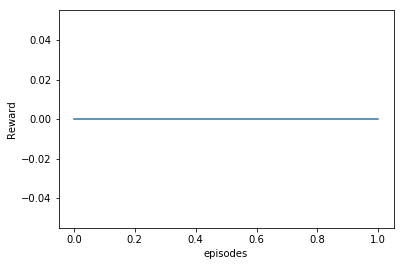

reward: 0
got score: [[0.91247916]]
estimated score: [[0.91247916]]
batch_size:  5
policy_loss: -0.5915112495422363, value_loss: 2.1961987018585205, entropy_loss: -1.3829363584518433
sum_reward for easyvapors.com is 0.0


started url http://vaportrail.com
control: Control: link, label: under 18, values: None, min: None, max = None
got probabilities: [3.2160622e-06 3.8585349e-06 3.6689514e-06 1.9694543e-01 6.0239984e-07
 8.0304325e-01]
got action: Do Nothing
control: Control: select, label: Date, values: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'
got probabilities: [1.6937986e-01 1.0233940e-05 2.1888077e-06 1.5503499e-06 9.7171858e-07
 8.3060515e-01]
got action: Do Nothing
reward: 0
got score: [[1.4762028]]
estimated score: [[1.4762028]]
control: Control: select, label: Month, values: ['January', 'February', 'March', 'April', 'May', 'June', 'Jul
got probabilities: [1.5584970e-06 2.1160856e-01 1.8356965e-06 9.8442717e-07 5.8783729e-07
 7.8838646e-01]
got action: Do No

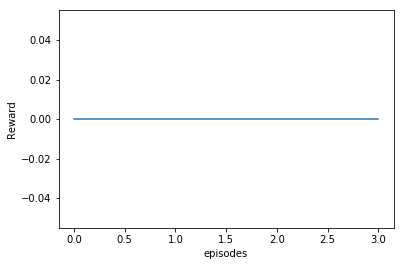

control: Control: button, label: YES, values: None, min: None, max = None
got probabilities: [4.7341209e-06 2.0399482e-05 3.8147959e-06 4.8258987e-01 1.0424457e-06
 5.1738012e-01]
got action: Click
control: Control: link, label: 	0, values: None, min: None, max = None
got probabilities: [7.5086291e-06 1.0953847e-05 1.5509804e-06 4.9253756e-01 6.5542690e-07
 5.0744170e-01]
got action: Do Nothing
reward: 0
got score: [[0.6893902]]
estimated score: [[0.6893902]]
control: Control: button, label: Follow @VapeALotShop, values: None, min: None, max = None
got probabilities: [1.3831888e-05 1.4148833e-05 1.2695510e-06 5.7593262e-01 3.6852228e-07
 4.2403775e-01]
got action: Do Nothing
reward: 0
got score: [[1.5134809]]
estimated score: [[1.5134809]]
control: Control: text, label: Search for:, values: None, min: None, max = None
got probabilities: [2.9123130e-01 3.9107594e-01 1.5121694e-01 1.1223799e-06 3.1356163e-02
 1.3511850e-01]
got action: Do Nothing
reward: 0
got score: [[0.6563573]]
estima

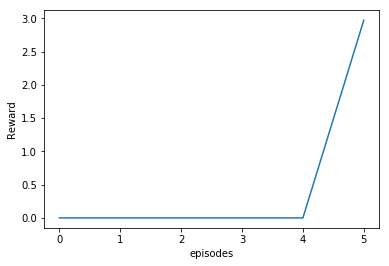

controls: 10, covered: 0
reward: 3
control: Control: link, label: , values: None, min: None, max = None
got score: [[1.4805111]]
estimated score: [[1.4805111]]
batch_size:  4
got probabilities: [4.5196202e-06 4.9916121e-06 6.2749968e-06 6.1795664e-01 1.0790847e-06
 3.8202646e-01]
got action: Click
policy_loss: 2.3143563270568848, value_loss: 3.9580647945404053, entropy_loss: -0.0
sum_reward for vaportrail.com is 2.88178803


started url http://madtownvap.com
control: Control: checkbox, label:  I am at least 18 years old, values: None, min: None, max = None
got probabilities: [3.9777101e-06 5.5482174e-06 4.5837905e-06 2.4718949e-01 8.0714574e-07
 7.5279558e-01]
got action: Do Nothing
reward: 0
got score: [[0.95240635]]
estimated score: [[0.95240635]]
control: Control: checkbox, label:  Remember me, values: None, min: None, max = None
got probabilities: [2.8317374e-06 4.6235027e-06 4.0321638e-06 2.5537333e-01 5.0592581e-07
 7.4461460e-01]
got action: Do Nothing
reward: 0
got score: [[0.9

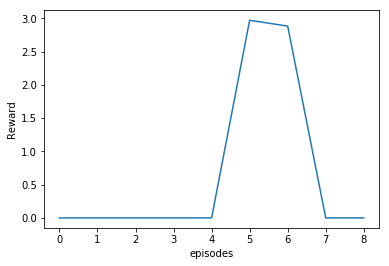

batch_size:  0
policy_loss: 0, value_loss: 0, entropy_loss: 0
sum_reward for euphoriavaporoutlet.com is 0.0


started url http://vaporhauschicago.com
control: Control: button, label: I am 18 or Older, values: None, min: None, max = None
got probabilities: [1.5006847e-06 6.1035917e-06 2.1066492e-06 1.0285889e-01 2.0809415e-07
 8.9713115e-01]
got action: Do Nothing
reward: 0
got score: [[1.7139416]]
estimated score: [[1.7139416]]
control: Control: button, label: I am Under 18, values: None, min: None, max = None
got probabilities: [1.2145923e-06 1.2422561e-05 5.6928457e-06 1.4395662e-01 3.1779439e-07
 8.5602373e-01]
got action: Do Nothing
control: Control: button, label: YES, values: None, min: None, max = None
got probabilities: [2.7570102e-06 7.4596765e-06 3.3491256e-06 4.0532905e-01 8.2221447e-07
 5.9465653e-01]
got action: Do Nothing
control: Control: button, label: Like422
, values: None, min: None, max = None
got probabilities: [6.4752144e-06 9.8040609e-06 2.1214703e-06 3.9976174e-

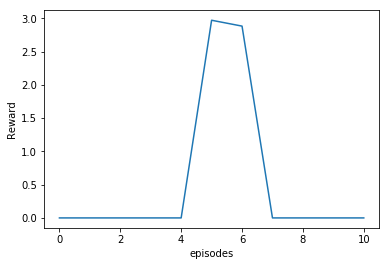

control: Control: text, label: 



GREAT PERFORMANCE
You'll be surprised to see the Final Results of your Cre
got probabilities: [2.8161657e-01 1.5725155e-01 1.0437871e-01 7.6539817e-07 5.3468615e-02
 4.0328389e-01]
got action: Do Nothing
reward: 0
got score: [[0.7653663]]
estimated score: [[0.7653663]]
batch_size:  2
policy_loss: -0.36097726225852966, value_loss: 0.31560051441192627, entropy_loss: -0.6367453932762146
sum_reward for madtownvap.com is 0.0


started url http://spartanvape.com
reward: 0
got score: [[1.3121797]]
estimated score: [[1.3121797]]
control: Control: button, label: I am Under 18, values: None, min: None, max = None
got probabilities: [1.8257373e-06 1.0128433e-05 8.2114748e-06 1.9375247e-01 5.4652111e-07
 8.0622685e-01]
got action: Do Nothing
reward: 0
got score: [[1.282556]]
estimated score: [[1.282556]]
control: Control: link, label: 



Website Age Checker & Age Verification Pop Up Script by AgeVerify.co, valu
got probabilities: [4.9262871e-06 4.0630844e-06 4.1

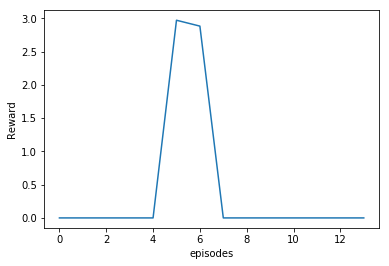

reward: 0
got score: [[1.244374]]
estimated score: [[1.244374]]
control: Control: link, label: 



Website Age Checker & Age Verification Pop Up Script by AgeVerify.co, valu
got probabilities: [8.9384257e-06 1.7050625e-05 1.6097354e-06 7.3915654e-01 7.9183752e-07
 2.6081508e-01]
got action: Click
reward: 0
got score: [[1.0045874]]
estimated score: [[1.0045874]]
control: Control: button, label: Share
, values: None, min: None, max = None
got probabilities: [8.3842424e-06 1.2356449e-05 2.6585153e-06 4.1666234e-01 5.6741254e-07
 5.8331376e-01]
got action: Do Nothing
controls: 10, covered: 0
reward: 0
got score: [[0.68722236]]
estimated score: [[0.68722236]]
batch_size:  2
policy_loss: -0.45566466450691223, value_loss: 2.030585289001465, entropy_loss: -0.49018627405166626
sum_reward for vapingsisters.com is 0.0


started url http://goodcigar.co
control: Control: button, label: , values: None, min: None, max = None
got probabilities: [1.0739956e-05 1.4639223e-05 1.9375120e-06 5.7761598e-01 

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://reelsmokers.net
reward: 0
got score: [[0.9026201]]
estimated score: [[0.9026201]]
control: Control: button, label: YES, values: None, min: None, max = None
got probabilities: [2.0989585e-06 1.5760486e-05 3.1508680e-06 3.3631375e-01 1.1752608e-06
 6.6366410e-01]
got action: Click
avg_reward: 0.390119202
reward: 0


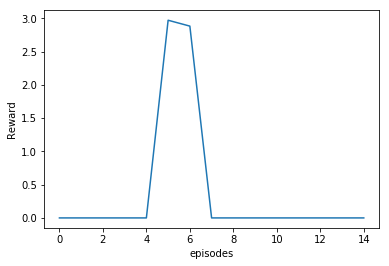

got score: [[1.0751188]]
estimated score: [[1.0751188]]
control: Control: link, label: Política de cookies, values: None, min: None, max = None
got probabilities: [2.8119689e-06 3.7147490e-06 6.4606515e-06 1.8848319e-01 6.0460002e-07
 8.1150323e-01]
got action: Do Nothing
controls: 10, covered: 1
reward: 3
got score: [[1.4345089]]
estimated score: [[1.4345089]]
batch_size:  3
policy_loss: 2.3635218143463135, value_loss: 4.465703010559082, entropy_loss: -0.0
sum_reward for goodcigar.co is 2.9108970000000003


started url http://vapedojo.com
reward: 0
got score: [[0.98160297]]
estimated score: [[0.98160297]]
control: Control: button, label: None, values: None, min: None, max = None
got probabilities: [1.1031629e-05 6.2536615e-06 2.2562124e-06 5.5618387e-01 5.5692368e-07
 4.4379607e-01]
got action: Click
reward: 0
got score: [[0.73284525]]
estimated score: [[0.73284525]]
control: Control: link, label: Condiciones de uso, values: None, min: None, max = None
got probabilities: [3.0568028e-0

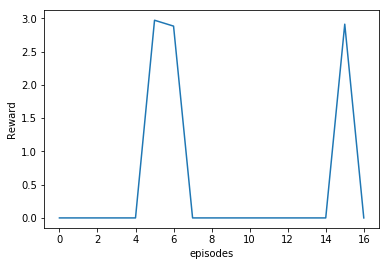

reward: 0
got score: [[1.0297458]]
estimated score: [[1.0297458]]
control: Control: link, label: Exit, values: None, min: None, max = None
got probabilities: [5.8588380e-06 5.8755963e-06 2.3952389e-06 4.6500677e-01 6.1746402e-07
 5.3497845e-01]
got action: Click
reward: 0
got score: [[0.79299945]]
estimated score: [[0.79299945]]
control: Control: button, label: Tengo +18 años y acepto, values: None, min: None, max = None
got probabilities: [2.2641150e-06 2.2206468e-06 2.6348112e-06 7.6337427e-02 4.7088116e-07
 9.2365503e-01]
got action: Do Nothing
reward: 0
got score: [[0.9879063]]
estimated score: [[0.9879063]]
control: Control: button, label: Sign up, values: None, min: None, max = None
got probabilities: [4.9563378e-06 3.8773665e-06 3.9124343e-06 3.7800851e-01 5.7916208e-07
 6.2197816e-01]
got action: Do Nothing
reward: 0
got score: [[0.88223857]]
estimated score: [[0.88223857]]
batch_size:  2
policy_loss: -0.6939096450805664, value_loss: 1.1457371711730957, entropy_loss: -0.5648040

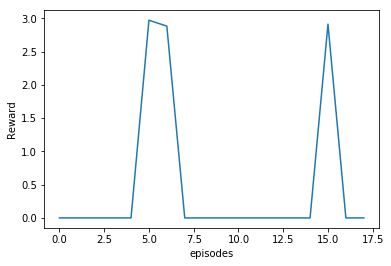

reward: 0
got score: [[0.89540845]]
estimated score: [[0.89540845]]
control: Control: button, label: ×, values: None, min: None, max = None
got probabilities: [3.5545131e-06 1.1900980e-05 2.9515227e-06 5.2893174e-01 1.0049513e-06
 4.7104883e-01]
got action: Click
control: Control: text, label: Last Name, values: None, min: None, max = None
got probabilities: [9.9030927e-02 1.9535895e-01 3.6481264e-01 1.1319969e-06 3.5620596e-02
 3.0517572e-01]
got action: InputBYear
reward: 0
got score: [[0.97101784]]
estimated score: [[0.97101784]]
control: Control: text, label: Enter your email address..., values: None, min: None, max = None
got probabilities: [8.9050688e-02 6.0978282e-02 4.1775388e-01 9.9138060e-07 4.2946652e-02
 3.8926953e-01]
got action: InputBYear
reward: 0
got score: [[0.5468624]]
estimated score: [[0.5468624]]
control: Control: text, label: Email Address, values: None, min: None, max = None
got probabilities: [2.9708141e-01 1.9617651e-01 1.5533583e-01 1.3304939e-06 2.2413805e-0

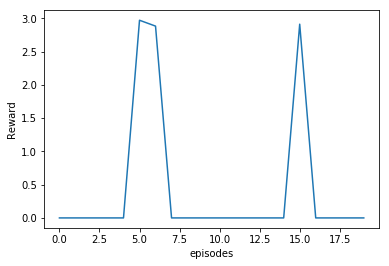

control: Control: button, label: I am 21 or Older, values: None, min: None, max = None
got probabilities: [3.0436361e-06 8.5472402e-06 5.5461119e-06 1.6439444e-01 8.2427891e-07
 8.3558762e-01]
got action: Click
controls: 10, covered: 2


started url http://norvap.com
reward: 0
got score: [[0.28594437]]
estimated score: [[0.28594437]]
control: Control: link, label: 
Share
, values: None, min: None, max = None
got probabilities: [4.3497794e-06 5.2286832e-06 8.9115042e-07 6.1768651e-01 2.8742869e-07
 3.8230267e-01]
got action: Click
controls: 10, covered: 0
reward: 3
got score: [[0.6520782]]
estimated score: [[0.6520782]]
batch_size:  1
policy_loss: 5.45556640625, value_loss: 3.181602716445923, entropy_loss: -0.0
sum_reward for glasvapor.com is 2.9699999999999998


started url http://fincigs.com
reward: 0
got score: [[1.1174754]]
estimated score: [[1.1174754]]
control: Control: button, label: Sign up, values: None, min: None, max = None
got probabilities: [8.1322651e-06 8.6278633e-06 5.41

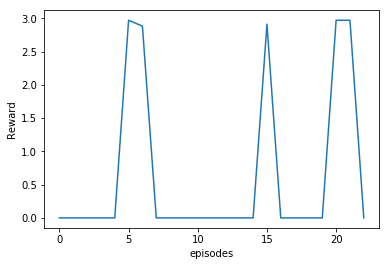

control: Control: button, label: Yes, values: None, min: None, max = None
got probabilities: [6.4580968e-06 8.5057509e-06 4.1523749e-06 5.9664023e-01 1.3870857e-06
 4.0333918e-01]
got action: Click
controls: 10, covered: 0
reward: 3
got score: [[0.80578804]]
estimated score: [[0.80578804]]
batch_size:  1
policy_loss: 0.3411799371242523, value_loss: 5.8206963539123535, entropy_loss: -0.0
sum_reward for sunnyvapes.com is 2.9699999999999998


started url http://vacavapes.com
reward: 0
got score: [[0.5122346]]
estimated score: [[0.5122346]]
batch_size:  4
policy_loss: -0.3996957540512085, value_loss: 0.49536895751953125, entropy_loss: -1.1917641162872314
sum_reward for cheaplittlecigaroutlet.com is 0.0


started url http://bangbangvapors.com
reward: 0
got score: [[0.94675034]]
estimated score: [[0.94675034]]
control: Control: link, label: Terms and Conditions., values: None, min: None, max = None
got probabilities: [1.0562817e-05 8.0806703e-06 2.2911263e-06 7.5521570e-01 4.4673450e-07
 2.4

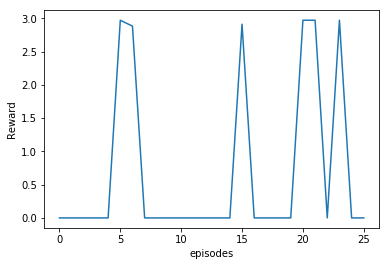

reward: 0
got score: [[1.1318051]]
estimated score: [[1.1318051]]
batch_size:  2
policy_loss: -1.0496225357055664, value_loss: 1.331519603729248, entropy_loss: -0.6434182524681091
sum_reward for bangbangvapors.com is 0.0


started url http://dropsofvapor.com
controls: 10, covered: 0
reward: 3
got score: [[0.5442368]]
estimated score: [[0.5442368]]
batch_size:  4
policy_loss: 2.1225836277008057, value_loss: 3.775879144668579, entropy_loss: -0.0
sum_reward for vacavapes.com is 2.88178803


started url http://ezvapors.com
control: Control: button, label: Enter, values: None, min: None, max = None
got probabilities: [4.6064401e-06 3.4214040e-06 2.1688695e-06 4.5277026e-01 1.4642090e-06
 5.4721802e-01]
got action: Do Nothing
control: Control: button, label: Under 18, values: None, min: None, max = None
got probabilities: [2.9256162e-06 1.0992231e-05 5.5883270e-06 6.5310031e-01 7.6904564e-07
 3.4687936e-01]
got action: Click
reward: 0
got score: [[0.8165424]]
estimated score: [[0.8165424]]
c

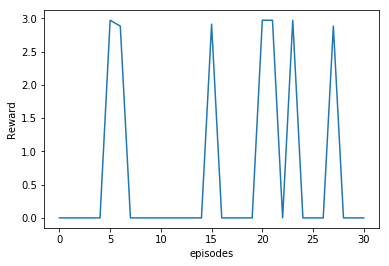

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://newfreedomvapor.com
control: Control: button, label: I am 21 or Older, values: None, min: None, max = None
got probabilities: [4.2097818e-06 8.0971276e-06 7.0617261e-06 4.5494217e-01 1.3912844e-06
 5.4503709e-01]
got action: Click
control: Control: button, label: None, values: None, min: None, max = None
got probabilities: [4.8367401e-06 3.8710532e-06 5.9817658e-06 4.6952108e-01 1.0757085e-06
 5.3046310e-01]
got action: Click
reward: 0
got score: [[0.4454367]]
estimated score: [[0.4454367]]
control: Control: button, label: None, values: None, min: None, max = None
got probabilities: [3.70547082e-06 2.65148105e-06 1.79573533e-06 8.84451509e-01
 7.57505461e-07 1.15539566e-01]
got action: Click
reward: 0
controls: 10, covered: 1
reward: 3
got score: [[0.8317756]]
estimated score: [[0.8317756]]
got score: [[0.6011887]]
estimated score: [[0.6011887]]
batch_size:  1
policy_loss: 2.1883726119995117, value_loss: 5.968964576721191, entropy_loss: -0.0
sum_reward for glasvapo

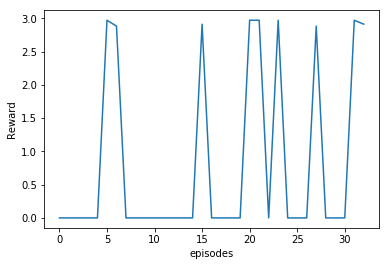

reward: 0
got score: [[0.8269508]]
estimated score: [[0.8269508]]
batch_size:  2
policy_loss: -0.9925475120544434, value_loss: 0.8194246292114258, entropy_loss: -0.5849968791007996
sum_reward for vape1111.com is 0.0


started url http://yaxelcigars.com
control: Control: button, label: 5, values: None, min: None, max = None
got probabilities: [5.9548997e-06 3.8373328e-06 1.4472298e-06 8.9526528e-01 8.8556180e-07
 1.0472265e-01]
got action: Click


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://globalvapery.com
reward: 0
got score: [[0.8522476]]
estimated score: [[0.8522476]]
batch_size:  1
policy_loss: -0.05067972466349602, value_loss: 0.27308401465415955, entropy_loss: -0.28088435530662537
sum_reward for vapor-riffic.com is 0.0


started url http://ezvapors.com
control: Control: button, label: Submit, values: None, min: None, max = None
got probabilities: [3.4489035e-06 7.8592975e-06 5.9483373e-06 6.0502881e-01 6.4881823e-07
 3.9495325e-01]
got action: Click
control: Control: button, label: Under 18, values: None, min: None, max = None
got probabilities: [2.4369679e-06 8.5663796e-06 4.9699493e-06 7.7216041e-01 6.9977284e-07
 2.2782283e-01]
got action: Click
controls: 10, covered: 2
reward: 0
got score: [[0.8238975]]
estimated score: [[0.8238975]]
batch_size:  1
policy_loss: -0.2070188671350479, value_loss: 0.5843663215637207, entropy_loss: -0.3273858428001404
sum_reward for ezvapors.com is 0.0


started url http://smokingnvaping.com
avg_reward: 0.734315

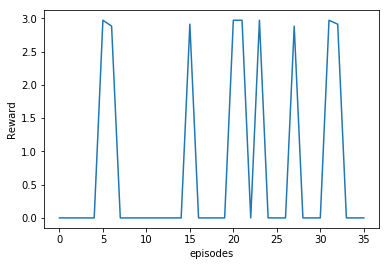

reward: 0
got score: [[0.46987876]]
estimated score: [[0.46987876]]
batch_size:  1
policy_loss: -0.19753007590770721, value_loss: 0.0884658694267273, entropy_loss: -0.2842390239238739
sum_reward for vapesolutionsdistributing.com is 0.0


started url http://voltvapes.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://mailboxvapes.com
control: Control: button, label: Yes! Grant me access!, values: None, min: None, max = None
got probabilities: [1.8439847e-06 2.9197913e-06 8.2014885e-06 7.4591106e-01 5.1926037e-07
 2.5407541e-01]
got action: Click
controls: 10, covered: 1
reward: 3
got score: [[1.0016026]]
estimated score: [[1.0016026]]
batch_size:  1
policy_loss: 1.328243613243103, value_loss: 3.118596076965332, entropy_loss: -0.0
sum_reward for voltvapes.com is 2.9699999999999998


started url http://vaporhauschicago.com
avg_reward: 0.7738255278947367


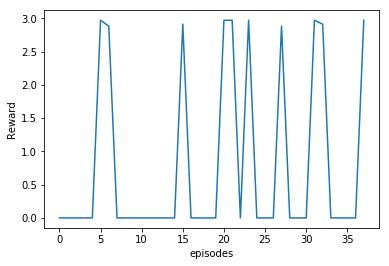

batch_size:  0
policy_loss: 0, value_loss: 0, entropy_loss: 0
sum_reward for smokingnvaping.com is 0.0


started url http://globalvapery.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://cityvaporplus.com
control: Control: button, label: I AM MY STATE'S LEGAL SMOKING AGE OR OLDER, values: None, min: None, max = N
got probabilities: [2.8096022e-06 4.2305652e-07 4.3698869e-06 8.0797958e-01 5.7772490e-07
 1.9201225e-01]
got action: Click
controls: 10, covered: 0
reward: 3
got score: [[0.6719015]]
estimated score: [[0.6719015]]
batch_size:  1
policy_loss: 0.6490864157676697, value_loss: 4.872621536254883, entropy_loss: -0.0
sum_reward for globalvapery.com is 2.9699999999999998


started url http://bestvapesale.com
avg_reward: 0.8093842514999998


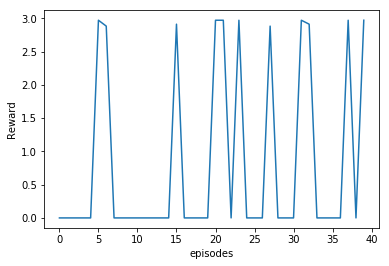

control: Control: text, label: Email or Phone, values: None, min: None, max = None
got probabilities: [2.9978004e-01 1.1916365e-01 1.7271081e-01 1.7394343e-06 1.2772091e-01
 2.8062284e-01]
got action: Input Email
control: Control: button, label: Like422
, values: None, min: None, max = None
got probabilities: [4.8401280e-06 3.2530927e-06 1.2535238e-06 8.8205343e-01 3.7922280e-07
 1.1793673e-01]
got action: Do Nothing


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://vapecraz3.com
avg_reward: 0.8093842514999998


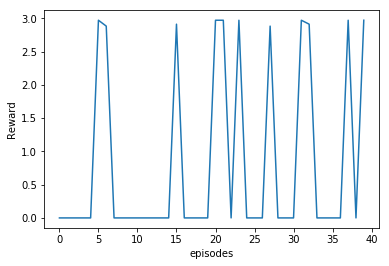

control: Control: button, label: Yes, values: None, min: None, max = None
got probabilities: [6.3251609e-06 3.0698025e-06 1.1343905e-06 6.6988564e-01 1.2842698e-06
 3.3010256e-01]
got action: Click
reward: 0
got score: [[1.3782693]]
estimated score: [[1.3782693]]
control: Control: button, label: Log In, values: None, min: None, max = None
got probabilities: [2.5908814e-06 2.4683113e-06 3.4370505e-06 7.2339523e-01 1.1143072e-06
 2.7659515e-01]
got action: Click


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://cheaplittlecigaroutlet.com
reward: 0
got score: [[0.7964822]]
estimated score: [[0.7964822]]
control: Control: link, label: 
Share
, values: None, min: None, max = None
got probabilities: [5.7064540e-06 4.1606181e-06 1.5491637e-06 8.5743111e-01 5.0765891e-07
 1.4255692e-01]
got action: Do Nothing
controls: 10, covered: 0
reward: 3
got score: [[1.1481158]]
estimated score: [[1.1481158]]
batch_size:  2
policy_loss: 2.6588432788848877, value_loss: 4.314451694488525, entropy_loss: -0.0
sum_reward for vaporhauschicago.com is 2.9402999999999997


started url http://bigchiefvapors.com
controls: 10, covered: 1
reward: 3
got score: [[0.6432136]]
estimated score: [[0.6432136]]
batch_size:  1
policy_loss: 0.9673234820365906, value_loss: 6.532299995422363, entropy_loss: -0.0
sum_reward for bestvapesale.com is 2.9699999999999998


started url http://bluelinevapor.com
avg_reward: 0.9115635728571427


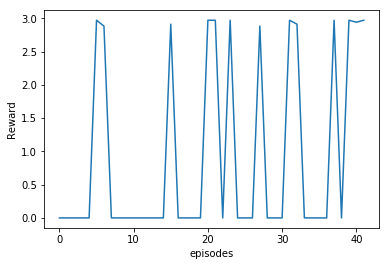

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://banzaivapors.com
control: Control: button, label: I AM NOT OF LEGAL SMOKING AGE, values: None, min: None, max = None
got probabilities: [4.1440662e-06 2.5087111e-06 7.6721408e-06 8.4007597e-01 1.0971387e-06
 1.5990856e-01]
got action: Click
control: Control: text, label:  GO!
Nav Menu 1
NEW PRODUCTS
POD SYSTEMS
PREMIUM E-LIQUID
CHIEF'S BLEND E-LIQU
got probabilities: [2.6558378e-01 1.6168299e-01 3.5071948e-01 7.3806109e-06 1.6198273e-01
 6.0023662e-02]
got action: InputBYear
reward: 0
got score: [[0.92091256]]
estimated score: [[0.92091256]]
control: Control: button, label: Share
, values: None, min: None, max = None
got probabilities: [4.9325877e-06 3.3757515e-06 1.3118320e-06 8.9031929e-01 4.7375082e-07
 1.0967057e-01]
got action: Click
reward: 0
got score: [[0.8054513]]
estimated score: [[0.8054513]]
batch_size:  1
policy_loss: -0.17026199400424957, value_loss: 1.2759991884231567, entropy_loss: -0.2896218001842499
sum_reward for bluelinevapor.com is 0.0


starte

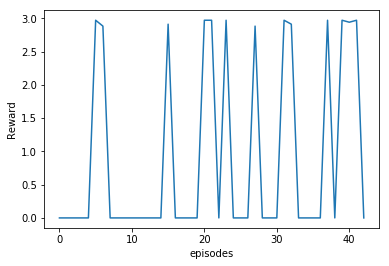

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://urgesmokeshop.com
control: Control: button, label: LEAVE NOW!
, values: None, min: None, max = None
got probabilities: [2.8488280e-06 3.3803062e-06 3.3392237e-06 7.7712661e-01 1.0609789e-06
 2.2286277e-01]
got action: Click
controls: 10, covered: 0
reward: 0
got score: [[0.18001723]]
estimated score: [[0.18001723]]
batch_size:  2
policy_loss: -0.7343612909317017, value_loss: 0.895330548286438, entropy_loss: -0.527782142162323
sum_reward for bigchiefvapors.com is 0.0


started url http://enhancedecigs.com
control: Control: select, label: Date, values: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'
got probabilities: [6.1544532e-01 1.2541363e-05 6.3044067e-06 2.8294271e-05 5.0337371e-06
 3.8450241e-01]
got action: InputBDay
reward: 0
got score: [[0.8892303]]
estimated score: [[0.8892303]]
control: Control: button, label: None, values: None, min: None, max = None
got probabilities: [6.5699655e-06 1.9926508e-06 1.0742106e-06 9.2950296e-01 3.8714418e-07


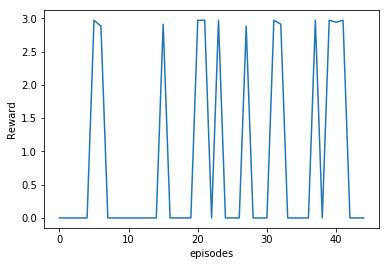

reward: 0
got score: [[0.82938284]]
estimated score: [[0.82938284]]
control: Control: checkbox, label: 	I confirm that I am 18 years or older., values: None, min: None, max = No
got probabilities: [5.9145655e-06 2.1233770e-06 9.9982781e-06 7.0958048e-01 2.5820102e-06
 2.9039887e-01]
got action: Click
reward: 0
got score: [[0.82596666]]
estimated score: [[0.82596666]]


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://xperiencevapes.com
control: Control: button, label: I am under 18, values: None, min: None, max = None
got probabilities: [2.5433958e-06 2.5982984e-06 3.4006853e-06 8.2423371e-01 8.7043549e-07
 1.7575683e-01]
got action: Click
reward: 0
got score: [[0.36178]]
estimated score: [[0.36178]]
control: Control: button, label: I am 18+, values: None, min: None, max = None
got probabilities: [3.1203438e-06 3.9094607e-06 3.7041575e-06 8.4934253e-01 7.7760143e-07
 1.5064590e-01]
got action: Click
reward: 0
got score: [[0.41687682]]
estimated score: [[0.41687682]]
batch_size:  6
policy_loss: -0.1941525936126709, value_loss: 0.5618335604667664, entropy_loss: -1.7776155471801758
sum_reward for enhancedecigs.com is 0.0


started url http://vaportrail.com
control: Control: button, label: FALL10, values: None, min: None, max = None
got probabilities: [5.8733826e-06 2.5989457e-06 3.5785606e-06 8.3086330e-01 1.2818025e-06
 1.6912329e-01]
got action: Click
avg_reward: 0.8322971752173

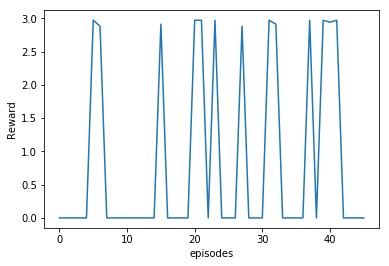

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://powervapes.net
reward: 0
got score: [[0.7994739]]
estimated score: [[0.7994739]]
control: Control: button, label: Sign up, values: None, min: None, max = None
got probabilities: [5.8428582e-06 2.4510728e-06 3.3000063e-06 7.9436702e-01 1.0362444e-06
 2.0562039e-01]
got action: Click
reward: 0
got score: [[1.0108509]]
estimated score: [[1.0108509]]
batch_size:  1
policy_loss: -0.4577975869178772, value_loss: 0.4023818373680115, entropy_loss: -0.32661113142967224
sum_reward for smokesmithgear.com is 0.0


started url http://xfirevapor.com
controls: 10, covered: 1


started url http://northsidecigars.com
avg_reward: 0.814588724680851


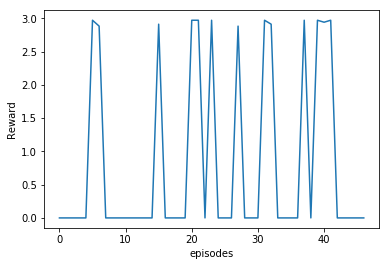

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://88vapors.com
control: Control: link, label: 	0, values: None, min: None, max = None
got probabilities: [3.9970923e-06 3.3030294e-06 8.5156756e-07 8.9853543e-01 6.0495569e-07
 1.0145586e-01]
got action: Click
control: Control: button, label: I am 18 & Over, values: None, min: None, max = None
got probabilities: [2.6664623e-06 7.9912161e-06 4.0136479e-06 7.5018191e-01 7.4001849e-07
 2.4980266e-01]
got action: Click
reward: 0
got score: [[0.9865723]]
estimated score: [[0.9865723]]
control: Control: button, label: Remind me later, values: None, min: None, max = None
got probabilities: [3.9301508e-06 2.0754610e-06 4.2587485e-06 8.8919276e-01 1.1265635e-06
 1.1079575e-01]
got action: Click
reward: 0
got score: [[0.20424563]]
estimated score: [[0.20424563]]
controls: 10, covered: 2
control: Control: text, label: Email Address, values: None, min: None, max = None
got probabilities: [4.8376423e-01 1.2891246e-01 1.3558301e-01 6.3511384e-06 8.1488855e-02
 1.7024511e-01]
got a

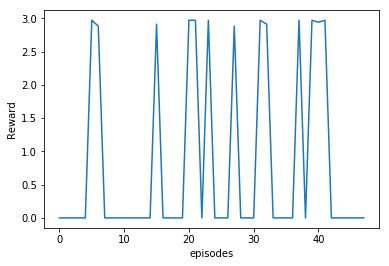

controls: 10, covered: 1
reward: 3
got score: [[0.865492]]
estimated score: [[0.865492]]
batch_size:  3
policy_loss: 0.5786319375038147, value_loss: 2.8946478366851807, entropy_loss: -0.0
sum_reward for northsidecigars.com is 2.9108970000000003


started url http://tpsvapor.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout
  (Session info: headless chrome=66.0.3359.181)
  (Driver info: chromedriver=2.40.565383 (76257d1ab79276b2d53ee976b2c3e3b9f335cde7),platform=Linux 4.15.0-34-generic x86_64)





started url http://octopusinkvapor.com
control: Control: text, label: 
   Shopping Cart - 0 item(s) / Total: $0
Search		

	
	HOME		MY ACCOUNT		ABOUT
got probabilities: [2.7423763e-01 1.6182865e-01 1.6522719e-01 2.2931999e-06 1.5633599e-01
 2.4236821e-01]
got action: InputBDay
control: Control: link, label: Age Verification FAQ, values: None, min: None, max = None
got probabilities: [4.4771487e-06 2.0504431e-06 1.6174748e-05 6.1684310e-01 1.3099079e-06
 3.8313285e-01]
got action: Click
reward: 0
got score: [[1.619074]]
estimated score: [[1.619074]]
control: Control: link, label: 



Website Age Checker & Age Verification Pop Up Script by AgeVerify.co, valu
got probabilities: [4.4992776e-06 2.8662166e-06 1.2540587e-06 8.5830361e-01 5.7709065e-07
 1.4168715e-01]
got action: Do Nothing
reward: 0
got score: [[0.9798511]]
estimated score: [[0.9798511]]
control: Control: link, label: AgeChecker.Net, values: None, min: None, max = None
got probabilities: [3.2285161e-06 2.0911132e-06 6.068739

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 297, in begin
    version, status, reason = self._read_status()
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 266, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconnected: Remote end closed connection without response

During handling 

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 376, in execute
    return self._request(command_info[0], url, body=data)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 399, in _request
    resp = self._conn.request(method, url, body=body, headers=headers)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File 



started url http://vacavapes.com


started url http://vapedojo.com


started url http://vape.sale


started url http://the-vape-place.com


started url http://chasin-vapors.com



Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 



started url http://urgesmokeshop.com


started url http://voltvapes.com
Traceback (most recent call last):
  File "/home/aleksei/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-efc22af6077e>", line 21, in <module>
    time.sleep(60)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/.local/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, 

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://hempirestatesmokeshop.com


started url http://ciggfreeds.com


  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/poolmanager.py", line 322, in urlopen
    response = conn.urlopen(method, u.request_uri, **kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 638, in urlopen
    _stacktrace=sys.exc_info()[2])
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/retry.py", line 398, in increment
    raise MaxRetryError(_pool, url, error or ResponseError(cause))
urllib3.exceptions.MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=35963): Max retries exceeded with url: /session/4ada3d2f9fc

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/home/aleksei/anaconda3/li

urllib3.exceptions.MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=35963): Max retries exceeded with url: /session/4ada3d2f9fcb27de5ac5e5158cdd3da9/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8d5cbd5c0>: Failed to establish a new connection: [Errno 111] Connection refused',))
Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/pyt

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://peachtreevapor.com


started url http://octopusinkvapor.com


started url http://cityvaporandecig.com


started url http://ecigsejuice.com


started url http://vapor-usa.com


started url http://lowpricedvape.com


started url http://vapesolutionsdistributing.com


started url http://realvapellc.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 376, in execute
    return self._request(command_info[0], url, body=data)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 399, in _request
    resp = self._conn.request(method, url, body=body, headers=headers)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 150, in request_encode_body
    return self.urlopen(



started url http://stogiesvapor.com


started url http://axisvapor.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 150, in request_encode_body
    return self.urlopen(method, url, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/poolmanager.py", line 322, in urlopen
    response = conn.urlopen(method, u.request_uri, **kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 638, in urlopen
    _stacktrace=sys.exc_info()[2])
  File "/home/aleksei/anaco

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/aleksei/an

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://bluelinevapor.com


started url http://vapersandpapers.com


started url http://nevadavapor.com


started url http://vapor-hub.com


started url http://myvapeshop-com.myshopify.com


started url http://steamspiritvapor.com


started url http://easyvapors.com


started url http://sincityvapor.com


started url http://thehouseofvapor.com


started url http://reelsmokers.net



During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/home/aleksei/anaconda3/li


  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_req

Traceback (most recent call last):
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)

  File "/home/aleksei/a

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://paradymecigs.com


started url http://cigarmanor.com


started url http://famousvapeinc.com


started url http://smokingnvaping.com


started url http://myvapeshop-com.myshopify.com


started url http://tattoovape.com


started url http://vapor-riffic.com


started url http://myvaporsparadise.com


started url http://xratedvapes.com


started url http://vapecraz3.com


started url http://myvaporsparadise.com


urllib3.exceptions.MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=35963): Max retries exceeded with url: /session/4ada3d2f9fcb27de5ac5e5158cdd3da9/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8d5aaa278>: Failed to establish a new connection: [Errno 111] Connection refused',))
Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/pyt

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://glassmonkeysmokeshops.com


started url http://smokescreenllc.com


started url http://cigarmanor.com


started url http://bonitasmokeshop.com


started url http://globalvapery.com


started url http://economyvapes.com


started url http://winnipesaukeecigar.com


started url http://vape-fuel.com


started url http://banzaivapors.com


started url http://vapor-usa.com


started url http://hempirestatesmokeshop.com


started url http://octopusinkvapor.com


Traceback (most recent call last):
    self.driver = common.create_chrome_driver(headless = self.headless)#, size=(1280, 1024))
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/selenium_utils/common.py", line 165, in create_chrome_driver
    return webdriver.Chrome(chrome_path, chrome_options=options)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/chrome/webdriver.py", line 73, in __init__
    self.service.start()
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/common/service.py", line 98, in start
    self.assert_process_still_running()
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/common/service.py", line 111, in assert_process_still_running
    % (self.path, return_code)
selenium.common.exceptions.WebDriverException: Message: Service /usr/bin/chromedriver unexpectedly exited. Status code was: -2


  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/en


  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_req

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://thesmokingglass.com


started url http://ecigmarket.com


started url http://sunnyvapes.com


started url http://vaporgalleria.com


started url http://cigarfactoryneworleans.com


started url http://hempirestatesmokeshop.com


started url http://madtownvap.com


started url http://banzaivapors.com


started url http://thesmokingglass.com


started url http://globalvapery.com


started url http://desertvapes.com


started url http://desertvapes.com


started url http://whatsyourvape.com



During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/home/aleksei/anaconda3/li

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1



started url http://famousvapeinc.com


started url http://premiumvaporsinc.com


started url http://smokesmartllc.com


started url http://tillberrysvapingelixirs.com


started url http://stogiesvapor.com


started url http://justvapez.com


started url http://premiumvaporsinc.com


started url http://xperiencevapes.com


started url http://northsidecigars.com


started url http://peachtreevapor.com


started url http://vapeclouds.com


started url http://smokescreenllc.com


started url http://powervapes.net


started url http://newfreedomvapor.com


Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_requ

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 376, in execute
    return self._request(command_info[0], url, body=data)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 399, in _request
    resp = self._conn.request(method, url, body=body, headers=headers)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 150, in request_encode_body
    return self.urlopen(

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):



started url http://desertvapes.com


started url http://cityvaporplus.com


started url http://mtnvapor.com


started url http://xratedvapes.com


started url http://easyvapors.com


started url http://steamspiritvapor.com


started url http://smokesmartllc.com


started url http://myvaporsparadise.com


started url http://sincityvapor.com


started url http://vapeldrs.com


started url http://vaporgalleria.com


started url http://secretcityvapors.com


started url http://sunnyvapes.com


started url http://smokingnvaping.com


started url http://claptonvapor.com


started url http://vapedojo.com


started url http://vaportrail.com



  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_req

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_requ

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, bod

urllib3.exceptions.MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=35963): Max retries exceeded with url: /session/4ada3d2f9fcb27de5ac5e5158cdd3da9/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8eccc6ac8>: Failed to establish a new connection: [Errno 111] Connection refused',))



started url http://vapeclouds.com


started url http://scvsmokeandvape.com


started url http://aspenvalleyvapes.com


started url http://cityvaporandecig.com


started url http://smokescreenllc.com


started url http://peachtreevapor.com


started url http://banzaivapors.com


started url http://realvapellc.com


started url http://vapeldrs.com


started url http://vapeldrs.com


started url http://lakeeffectvapor.com


started url http://vapeclouds.com


started url http://justvapez.com


started url http://lakeshorevapors.com


started url http://vapecraz3.com


started url http://chasin-vapors.com



Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_requ

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 376, in execute
    return self._request(command_info[0], url, body=data)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 399, in _request
    resp = self._conn.request(method, url, body=body, headers=headers)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 150, in request_encode_body
    return self.urlopen(method, url, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/poolmanager.py", line 322, in urlopen
    response = conn.urlopen(method, u.request_uri, **kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/p

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_requ

  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 667, in urlopen
    **response_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 638, in urlopen
    _stacktrace=sys.exc_info()[2])
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/retry.py", line 398, in increment
    raise MaxRetryError(_pool, url, error or ResponseError(cause))
urllib3.exceptions.MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=35963): Max retries exceeded with url: /session/4ada3d2f9fcb27de5ac5e5158cdd3da9/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8d5d04898>: Failed to establish a new connection: [Errno



started url http://tpsvapor.com


started url http://ecigmarket.com


started url http://mailboxvapes.com


started url http://vapingsisters.com


started url http://madtownvap.com


started url http://canoncigars.com


started url http://soulvaporejuice.com


started url http://cityvaporplus.com


started url http://bonitasmokeshop.com


started url http://axisvapor.com


started url http://venumvapur.com


  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/tracing/rl/environment.py", line 58, in start
    self.driver.get(url)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 376, in execute
    return self._request(command_info[0], url, body=data)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/selenium/webdriver/remote/remote_connection.py", line 399, in _request
    resp = self._conn.request(method, url, body=body, headers=headers)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/request.py", line 72, in request
    **urlopen_kw)
  File 

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 79, in create_connection
    raise err
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/aleksei/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/aleksei/anaconda3/lib/python3.6/http/client.py", line 1

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def start(worker):
    while True:
        try:
            worker.run()
            break
        except:
            pass
        

threads = []
for worker in workers:
    thread = threading.Thread(target=lambda: start(worker))
    thread.start()
    threads.append(thread)

while True:
    time.sleep(60)
    
    rewards = ActorLearnerWorker.step_rewards[:]
    if len(rewards) > 0:
        print('avg_reward:', sum(rewards) / len(rewards))
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('episodes')
    plt.ylabel('Reward')
    plt.show()
    
coord.join(threads)

In [ ]:
from tracing.selenium_utils import common

driver = common.create_chrome_driver(size=(1280, 1024))
driver.get('http://voltvapes.com')

In [ ]:
from tracing.selenium_utils import common
from tracing.selenium_utils import controls

frames = common.get_frames(driver)
print(frames)
for frame in frames:
    if frame:
        driver.switch_to.frame(frame)
    
    ctrls = controls.extract_controls(driver)
    for ctrl in ctrls:
        print(str(ctrl)[:100])
    
    if frame:
        driver.switch_to.default_content()

In [ ]:
driver.quit()

started
Control: button, label: Yes! Grant me access!, values: None, min: None, max = None


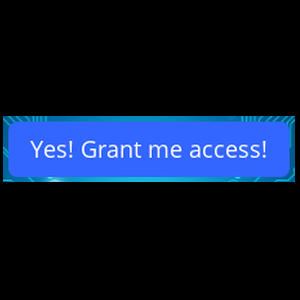

Control: link, label: Nope! Send me away!, values: None, min: None, max = None


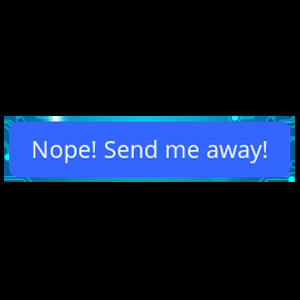

In [3]:
from tracing.rl.actor_learner import ActionsMemory
from tracing.rl.environment import Environment
from tracing.rl.actions import *
from tracing.rl.a3cmodel import A3CModel
from tracing.rl.rewards import PopupRewardsCalculator
from tracing.rl.environment import Environment
from tracing.rl.actor_learner import ActorLearnerWorker
import threading
import numpy as np
import PIL
import time

from IPython.display import display, Image

env = Environment(PopupRewardsCalculator(), user={}, headless=True)
with env:
    #env.start('docssmokeshop.com')
    env.start('voltvapes.com')
    print('started')
    while env.has_next_control():
        ctrl = env.get_next_control()
        
        print(str(ctrl)[:100])
        inp = env.get_control_as_input(ctrl)
         
        rgb = (inp * 128 + 128).astype(np.uint8)
        img = PIL.Image.fromarray(rgb, 'RGB')
        img.save('test.png')
        display(Image(filename='test.png'))
        

In [ ]:
batch = memory.to_input()

self = global_model

feed_dict = {self.img: batch['img'], 
             self.dropout: 1.0,
             self.possible_actions: batch['possible_actions'],
             self.performed_actions: [4, 3],
             self.rewards: [3, 3],
             self.lr: 0.01,
             self.er: 0.002
            }

net_v = session.run(self.net, feed_dict)
print(net_v[0, :])

feed_dict_1 = {self.img: [batch['img'][0]], 
             self.dropout: 1.0,
             self.possible_actions: [batch['possible_actions'][0]],
             self.performed_actions: [4],
             self.rewards: [3],
             self.lr: 0.01,
             self.er: 0.002
            }

net_1 = session.run(self.net, feed_dict=feed_dict_1)
print(net_1[0, :])

#pl, el, vl = session.run([self.policy_loss, self.entropy_loss, self.value_loss], feed_dict)
#print(pl, el, vl)

session.run(self.train_op, feed_dict = feed_dict_1)

print(net_v.shape)

In [ ]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import nets.nasnet.pnasnet
import nets.inception_resnet_v2
from nets.inception_utils import inception_arg_scope

import numpy as np


tf.reset_default_graph()
num_actions = len(Actions.actions)

img = tf.placeholder(tf.float32, (None, 224, 224, 3), "img")

#net, endpoints = nets.nasnet.pnasnet.build_pnasnet_mobile(img, None, is_training=True)
with slim.arg_scope(inception_arg_scope()):
    net, endpoints = nets.inception_resnet_v2.inception_resnet_v2(img, None)
    
fc2 = slim.fully_connected(net, 100)
logits = slim.fully_connected(fc2, num_actions, activation_fn=None)
pi = tf.nn.softmax(logits)

In [ ]:
# Test Environment
from tracing.selenium_utils.common import *

env = Environment(PopupRewardsCalculator(), user={}, headless=False)

with env:
    env.start('enhancedecigs.com')

    ctrls = env.get_controls()
    assert len(ctrls) == 6

    dayCtrl = ctrls[0]
    monthCtrl = ctrls[1]
    yearCtrl = ctrls[2]
    check = ctrls[3]
    enter = ctrls[5]

    assert env.apply_action(dayCtrl, InputBDay()) == 0
    assert env.apply_action(monthCtrl, InputBMonth()) == 0
    assert env.apply_action(yearCtrl, InputBYear()) == 0
    assert env.apply_action(check, Click()) == 0
    assert env.apply_action(enter, Click()) == 100

    assert env.calc_final_reward() == 0


In [ ]:
# Test Popups Detecting

import time

rewards = PopupRewardsCalculator()

driver = create_chrome_driver()

for url in no_popup_urls:
    print('url: ', url)
    driver.get('http://' + url)
    time.sleep(2)
    assert not rewards.is_popup_exists(driver)

for url in popup_urls:
    print('url: ', url)
    driver.get('http://' + url)
    time.sleep(2)
    assert rewards.is_popup_exists(driver)

driver.quit()    